# SH2SHNet Results Analysis

This notebook analyzes the performance of the trained SH2SHNet model on tensor tomography reconstructions.

We will:
1. Load the test dataset and trained model
2. Generate predictions for the test set
3. Compute statistical metrics (MSE, MAE, per-coefficient errors)
4. Visualize spherical harmonic functions in real space
5. Compare sparse, predicted, and ground truth reconstructions

In [1]:
import sys
sys.path.insert(0, '/myhome/smartt')

import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
from tqdm import tqdm

# Import smartt modules
from smartt.dataset import ReconstructionDataset
from smartt.models.sh2shnet import SH2SHNet
from smartt.training.train_sparse_sh import (
    pad_mumott_to_e3nn, 
    extract_even_l_from_e3nn
)

# Import mumott visualization tools
from mumott.methods.basis_sets import SphericalHarmonics
from mumott_plotting.map_plots import plot_on_polefigure, make_scattering_vector_plot
from mumott_plotting.tomogram_plots import plot_scalar_slices

%matplotlib inline

INFO:Setting the number of threads to 8. If your physical cores are fewer than this number, you may want to use numba.set_num_threads(n), and os.environ["OPENBLAS_NUM_THREADS"] = f"{n}" to set the number of threads to the number of physical cores n.
INFO:Setting numba log level to WARNING.


## 1. Load Dataset and Model

In [44]:
# Paths
data_path = '/myhome/data/smartt/shared/subsets_frogbone_test/subset_dataset.h5'
checkpoint_path = '/myhome/smartt/checkpoints/sh2shnet_v2.pt'

# Load full dataset
full_dataset = ReconstructionDataset(
    hdf5_path=data_path,
    return_ground_truth=True,
    load_in_memory=True,
    return_metadata=False,
    granularity='coarse'
)

print(f"Dataset info:")
print(f"  Total samples: {len(full_dataset)}")
print(f"  Volume shape: {full_dataset.volume_shape}")
print(f"  Num coefficients: {full_dataset.num_coefficients}")
print(f"  ell_max: {full_dataset.ell_max}")
print(f"  Num projections (sparse): {full_dataset.num_projections}")

Dataset info:
  Total samples: 2
  Volume shape: (65, 82, 65)
  Num coefficients: 45
  ell_max: 8
  Num projections (sparse): 60


In [48]:
# Split into train and test (same as training script)
from torch.utils.data import random_split

train_split = 0.8
seed = 42

total_size = len(full_dataset)
train_size = int(train_split * total_size)
test_size = total_size - train_size

generator = torch.Generator().manual_seed(seed)
train_ds, test_ds = random_split(
    full_dataset, 
    [train_size, test_size],
    generator=generator
)

print(f"\nSplit into:")
print(f"  Training samples: {len(train_ds)}")
print(f"  Test samples: {len(test_ds)}")


Split into:
  Training samples: 1
  Test samples: 1


In [4]:
# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = SH2SHNet(
    lmax_in=8,
    lmax_out=8,
    lmax_hidden=12,
    mul_non_scalar=4,
    scalars_hidden=16,
    n_blocks=3
)

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)

model.to(device)
model.eval()

print(f"\nModel loaded from: {checkpoint_path}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cuda

Model loaded from: /myhome/smartt/checkpoints/sh2shnet_v2.pt
Total parameters: 2,576


## 2. Generate Predictions for Test Set

In [63]:
# Create DataLoader for batch processing
from torch.utils.data import DataLoader

batch_size = 1
test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print(f"Processing test set in batches of {batch_size}...")

# Generate predictions for all test samples
test_results = []

with torch.no_grad():
    for sparse_batch, gt_batch in tqdm(test_loader, desc="Predicting"):
        # Move to device
        sparse_batch = sparse_batch.float().to(device)
        shape_before = gt_batch.shape
        sparse_batch = sparse_batch.reshape(-1, 45)
        
        # Pad to e3nn format
        sparse_e3nn = pad_mumott_to_e3nn(sparse_batch, lmax=8)
        
        # Forward pass
        pred_e3nn = model(sparse_e3nn)
        
        # Extract even-ℓ coefficients
        pred_batch = extract_even_l_from_e3nn(pred_e3nn, lmax=8)

        pred_batch = pred_batch.reshape(shape_before)
        sparse_batch = sparse_batch.reshape(shape_before)
        
        # Store results
        sparse_np = sparse_batch.cpu().numpy()[0]
        pred_np = pred_batch.cpu().numpy()[0]
        gt_np = gt_batch.numpy()[0]
        
        test_results.append({
            'sparse': sparse_np,
            'predicted': pred_np,
            'ground_truth': gt_np
        })
            

print(f"\nGenerated predictions for {len(test_results)} test samples")

Processing test set in batches of 1...


Predicting: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Generated predictions for 1 test samples


## 3. Statistical Analysis

In [64]:
# Compute metrics for all test samples
metrics = {
    'sparse_vs_gt': {'mse': [], 'mae': [], 'per_coeff_mse': []},
    'predicted_vs_gt': {'mse': [], 'mae': [], 'per_coeff_mse': []}
}

for result in test_results:
    sparse = result['sparse']
    predicted = result['predicted']
    gt = result['ground_truth']
    
    # Sparse vs ground truth
    sparse_error = sparse - gt
    metrics['sparse_vs_gt']['mse'].append(np.mean(sparse_error**2))
    metrics['sparse_vs_gt']['mae'].append(np.mean(np.abs(sparse_error)))
    metrics['sparse_vs_gt']['per_coeff_mse'].append(np.mean(sparse_error**2, axis=(0,1,2)))
    
    # Predicted vs ground truth
    pred_error = predicted - gt
    metrics['predicted_vs_gt']['mse'].append(np.mean(pred_error**2))
    metrics['predicted_vs_gt']['mae'].append(np.mean(np.abs(pred_error)))
    metrics['predicted_vs_gt']['per_coeff_mse'].append(np.mean(pred_error**2, axis=(0,1,2)))

# Aggregate metrics
print("=" * 60)
print("STATISTICAL METRICS OVER TEST SET")
print("=" * 60)
print(f"\nNumber of test samples: {len(test_results)}")
print(f"\n{'Metric':<25} {'Sparse vs GT':<20} {'Predicted vs GT':<20}")
print("-" * 65)

sparse_mse = np.mean(metrics['sparse_vs_gt']['mse'])
pred_mse = np.mean(metrics['predicted_vs_gt']['mse'])
print(f"{'MSE (mean)':<25} {sparse_mse:<20.6f} {pred_mse:<20.6f}")

sparse_mae = np.mean(metrics['sparse_vs_gt']['mae'])
pred_mae = np.mean(metrics['predicted_vs_gt']['mae'])
print(f"{'MAE (mean)':<25} {sparse_mae:<20.6f} {pred_mae:<20.6f}")

improvement_mse = (sparse_mse - pred_mse) / sparse_mse * 100
improvement_mae = (sparse_mae - pred_mae) / sparse_mae * 100
print(f"\n{'Improvement (%)':<25} {improvement_mse:<20.2f} {improvement_mae:<20.2f}")
print("=" * 60)

STATISTICAL METRICS OVER TEST SET

Number of test samples: 1

Metric                    Sparse vs GT         Predicted vs GT     
-----------------------------------------------------------------
MSE (mean)                56.359531            53.194744           
MAE (mean)                4.463819             4.209363            

Improvement (%)           5.62                 5.70                


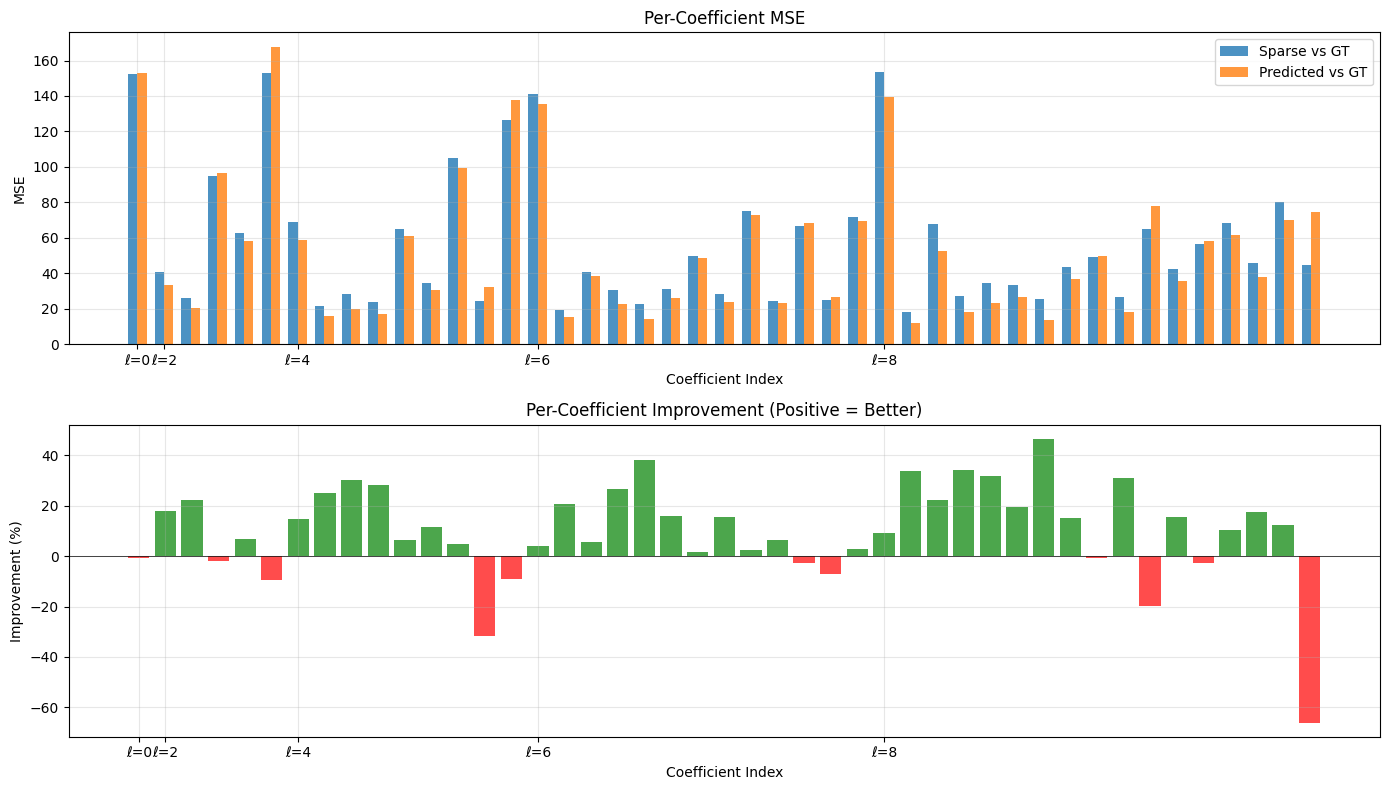

In [65]:
# Per-coefficient error analysis
sparse_per_coeff = np.mean(metrics['sparse_vs_gt']['per_coeff_mse'], axis=0)
pred_per_coeff = np.mean(metrics['predicted_vs_gt']['per_coeff_mse'], axis=0)

# Map coefficient indices to (ℓ, m) pairs for even-ℓ only
ell_indices = []
emm_indices = []
for l in [0, 2, 4, 6, 8]:
    for m in range(-l, l+1):
        ell_indices.append(l)
        emm_indices.append(m)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# MSE per coefficient
x = np.arange(45)
width = 0.35
axes[0].bar(x - width/2, sparse_per_coeff, width, label='Sparse vs GT', alpha=0.8)
axes[0].bar(x + width/2, pred_per_coeff, width, label='Predicted vs GT', alpha=0.8)
axes[0].set_xlabel('Coefficient Index')
axes[0].set_ylabel('MSE')
axes[0].set_title('Per-Coefficient MSE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Improvement per coefficient
improvement_per_coeff = (sparse_per_coeff - pred_per_coeff) / sparse_per_coeff * 100
colors = ['green' if x > 0 else 'red' for x in improvement_per_coeff]
axes[1].bar(x, improvement_per_coeff, color=colors, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Coefficient Index')
axes[1].set_ylabel('Improvement (%)')
axes[1].set_title('Per-Coefficient Improvement (Positive = Better)')
axes[1].grid(True, alpha=0.3)

# Add ℓ value labels
for ax in axes:
    ax.set_xticks([0, 1, 6, 15, 28])
    ax.set_xticklabels(['ℓ=0', 'ℓ=2', 'ℓ=4', 'ℓ=6', 'ℓ=8'])

plt.tight_layout()
plt.show()

## 4. Visualize Spherical Harmonic Functions

In [66]:
# Initialize mumott spherical harmonics basis
basis_set = SphericalHarmonics(ell_max=8)

print(f"Basis set:")
print(f"  ell_max: {basis_set.ell_max}")
print(f"  Number of coefficients: {len(basis_set)}")
print(f"  ell_indices: {basis_set.ell_indices}")
print(f"  emm_indices: {basis_set.emm_indices}")

Basis set:
  ell_max: 8
  Number of coefficients: 45
  ell_indices: [0 2 2 2 2 2 4 4 4 4 4 4 4 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8]
  emm_indices: [ 0 -2 -1  0  1  2 -4 -3 -2 -1  0  1  2  3  4 -6 -5 -4 -3 -2 -1  0  1  2
  3  4  5  6 -8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8]


In [67]:
def visualize_sh_function(coefficients, title="Spherical Harmonic Function", figsize=(14, 5)):
    """
    Visualize a spherical harmonic function using mumott's plotting tools.
    
    Parameters
    ----------
    coefficients : np.ndarray
        Array of 45 spherical harmonic coefficients
    title : str
        Title for the plot
    figsize : tuple
        Figure size
    """
    fig = plt.figure(figsize=figsize)
    
    # Pole figure (2D projection)
    ax1 = plt.subplot(1, 2, 1, polar=True)
    map_intensity, map_theta, map_phi = basis_set.generate_map(
        coefficients, 
        map_half_sphere=True, 
        resolution_in_degrees=2
    )
    plot_on_polefigure(ax1, map_intensity, map_theta, map_phi)
    ax1.set_title('Pole Figure (2D)')
    
    # 3D scattering vector plot
    ax2 = plt.subplot(1, 2, 2, projection='3d')
    map_intensity, map_theta, map_phi = basis_set.generate_map(
        coefficients, 
        map_half_sphere=False, 
        resolution_in_degrees=5
    )
    surface = make_scattering_vector_plot(ax2, map_intensity, map_theta, map_phi)
    ax2.set_title('3D Scattering Pattern')
    
    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 5. Example Voxel Comparisons

Let's look at specific voxels and compare sparse, predicted, and ground truth reconstructions.

In [68]:
# Select a test sample
sample_idx = 0  # Change this to look at different samples
result = test_results[sample_idx]

sparse = result['sparse']
predicted = result['predicted']
gt = result['ground_truth']

print(f"Analyzing test sample {sample_idx}")
print(f"Volume shape: {sparse.shape[:3]}")
print(f"Number of coefficients: {sparse.shape[3]}")

Analyzing test sample 0
Volume shape: (65, 82, 65)
Number of coefficients: 45


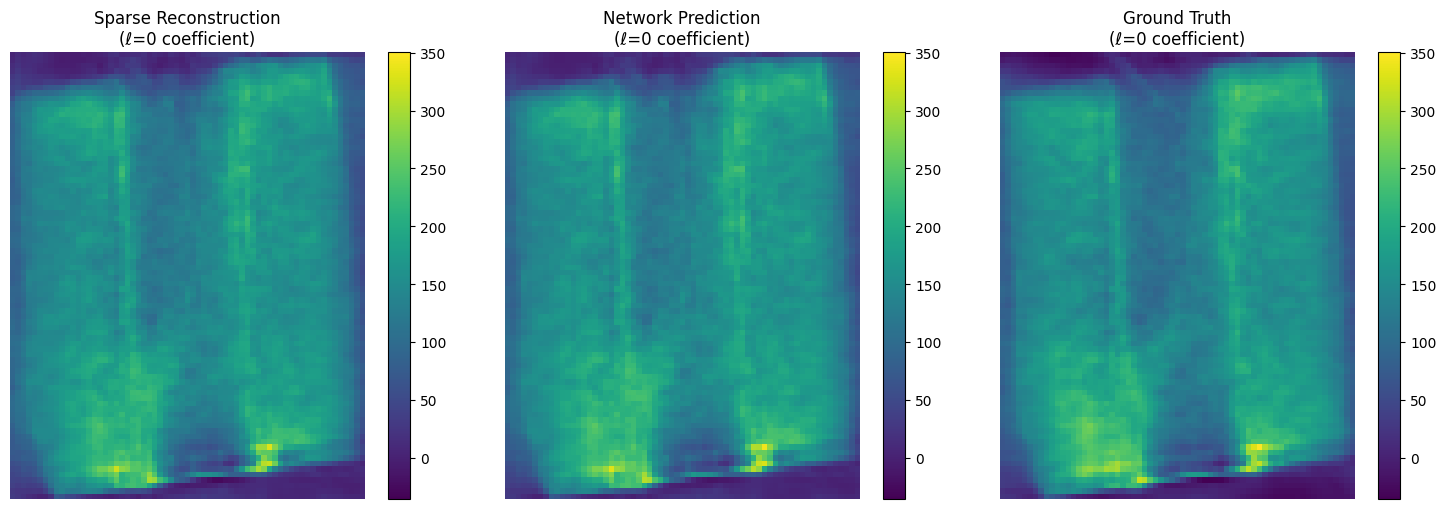

In [69]:
# Visualize the isotropic component (ℓ=0 coefficient)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot middle slices of isotropic component
mid_z = sparse.shape[2] // 2

vmin = min(sparse[:, :, mid_z, 0].min(), predicted[:, :, mid_z, 0].min(), gt[:, :, mid_z, 0].min())
vmax = max(sparse[:, :, mid_z, 0].max(), predicted[:, :, mid_z, 0].max(), gt[:, :, mid_z, 0].max())

im0 = axes[0].imshow(sparse[:, :, mid_z, 0].T, cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].set_title('Sparse Reconstruction\n(ℓ=0 coefficient)')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(predicted[:, :, mid_z, 0].T, cmap='viridis', vmin=vmin, vmax=vmax)
axes[1].set_title('Network Prediction\n(ℓ=0 coefficient)')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(gt[:, :, mid_z, 0].T, cmap='viridis', vmin=vmin, vmax=vmax)
axes[2].set_title('Ground Truth\n(ℓ=0 coefficient)')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

In [81]:
# Find interesting voxels (high anisotropy)
# Compute anisotropy as sum of squared coefficients excluding ℓ=0
anisotropy_sparse = np.sum(sparse[..., 1:]**2, axis=-1)
anisotropy_gt = np.sum(gt[..., 1:]**2, axis=-1)

# Find voxels with high ground truth anisotropy
threshold = np.percentile(anisotropy_gt, 90)
high_aniso_mask = anisotropy_gt > threshold

# Get coordinates of high anisotropy voxels
high_aniso_coords = np.argwhere(high_aniso_mask)

print(f"Number of voxels with high anisotropy: {len(high_aniso_coords)}")
print(f"Anisotropy threshold (90th percentile): {threshold:.6f}")

# Select a few example voxels
num_selected_voxels = 5
example_voxels = high_aniso_coords[::len(high_aniso_coords)//num_selected_voxels][:num_selected_voxels]  # Select num_selected_voxels evenly spaced

print(f"\nSelected example voxels:")
for i, voxel in enumerate(example_voxels):
    print(f"  {i+1}. Position {tuple(voxel)}, Anisotropy: {anisotropy_gt[tuple(voxel)]:.6f}")

Number of voxels with high anisotropy: 34645
Anisotropy threshold (90th percentile): 17643.488477

Selected example voxels:
  1. Position (0, 75, 31), Anisotropy: 17931.248047
  2. Position (19, 71, 43), Anisotropy: 24923.509766
  3. Position (23, 70, 45), Anisotropy: 45399.496094
  4. Position (27, 76, 55), Anisotropy: 55031.652344
  5. Position (40, 74, 7), Anisotropy: 20209.546875


### Visualize Individual Voxels


VOXEL 1: Position (0, 75, 31)
MSE (Sparse vs GT): 63.950054
MSE (Predicted vs GT): 113.594528
Improvement: -77.63%

Sparse Reconstruction:


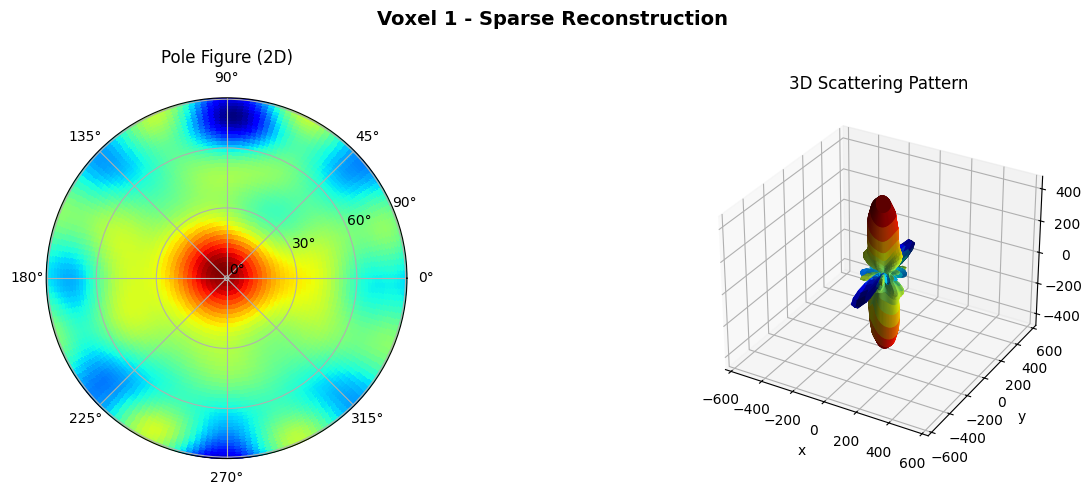


Network Prediction:


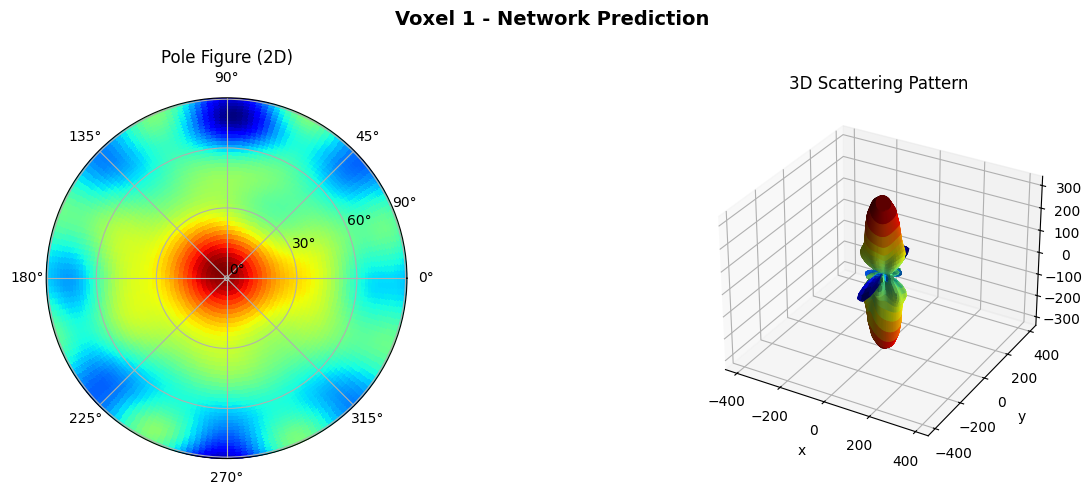


Ground Truth:


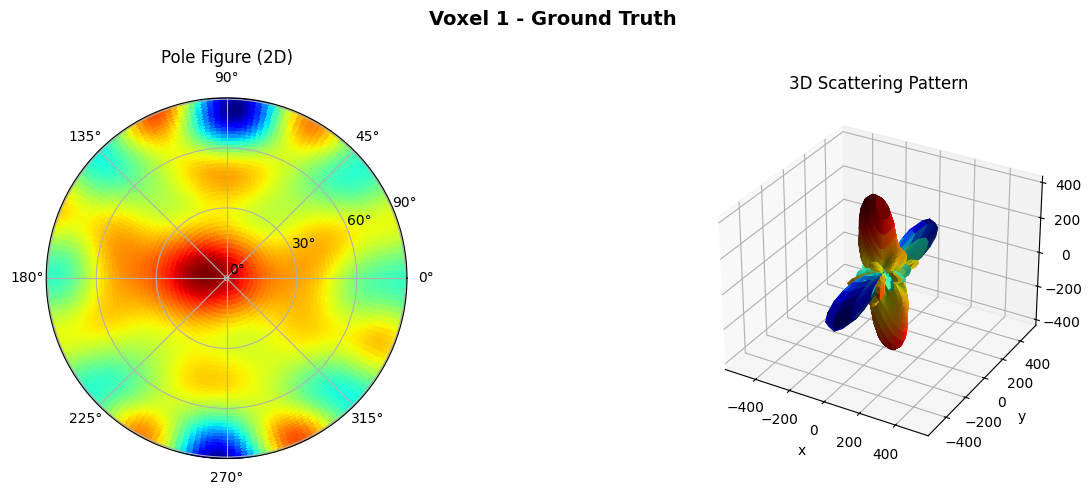


VOXEL 2: Position (19, 71, 43)
MSE (Sparse vs GT): 27.458067
MSE (Predicted vs GT): 45.087147
Improvement: -64.20%

Sparse Reconstruction:


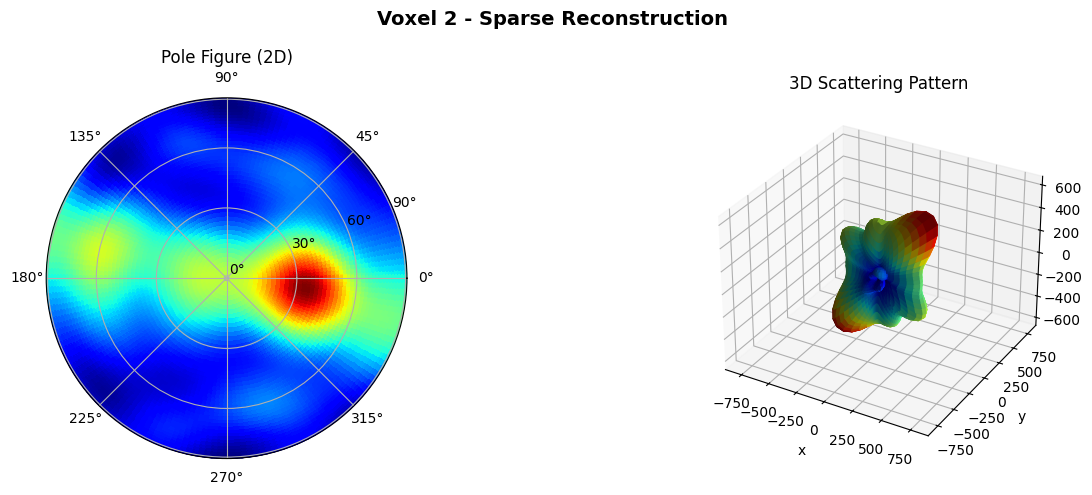


Network Prediction:


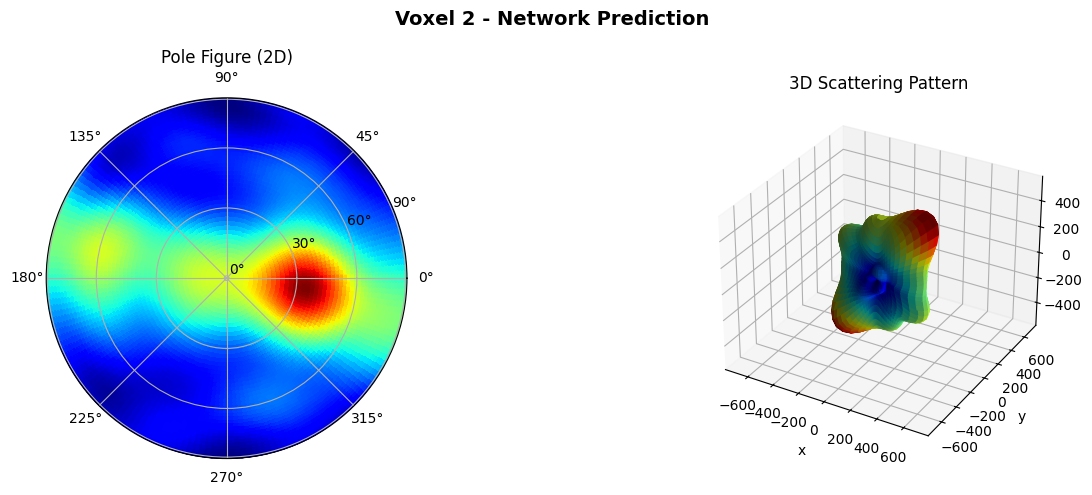


Ground Truth:


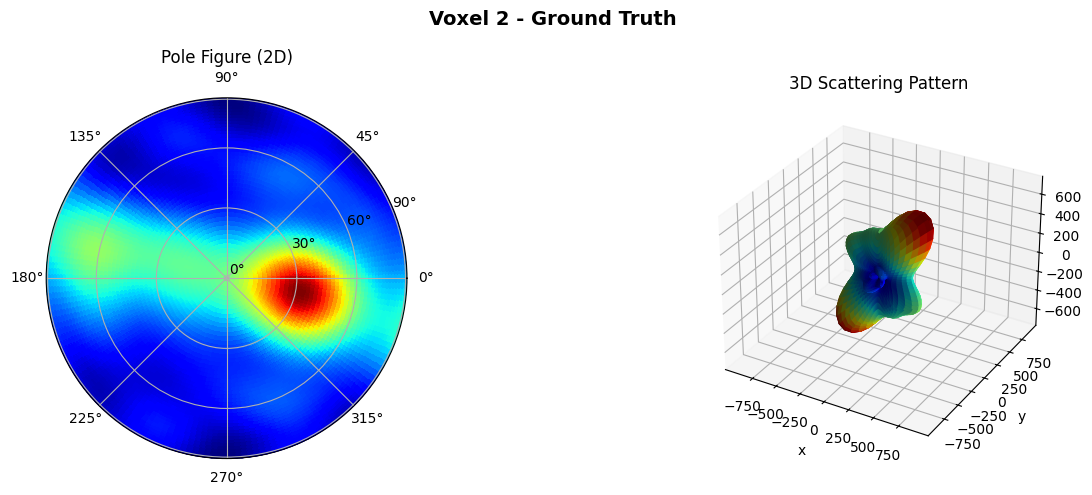


VOXEL 3: Position (23, 70, 45)
MSE (Sparse vs GT): 39.304565
MSE (Predicted vs GT): 60.336193
Improvement: -53.51%

Sparse Reconstruction:


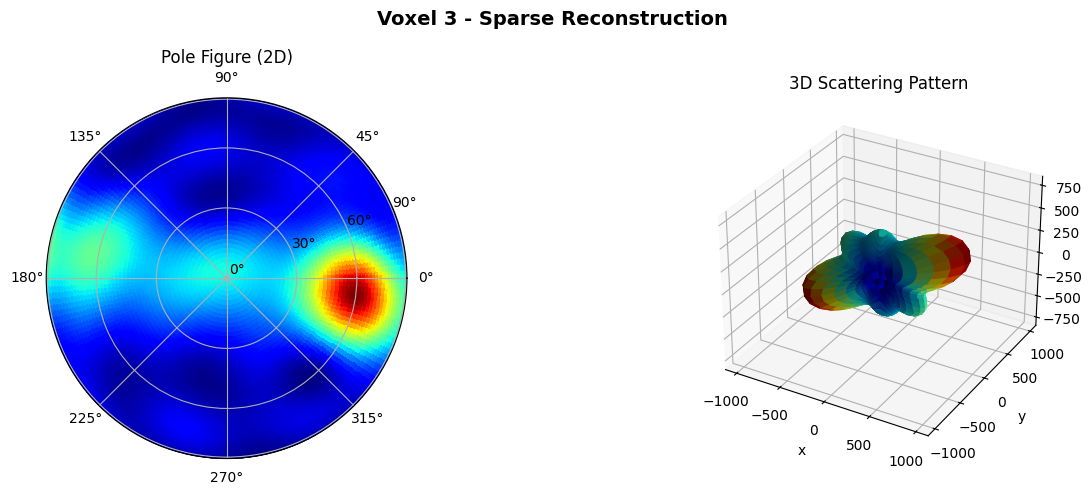


Network Prediction:


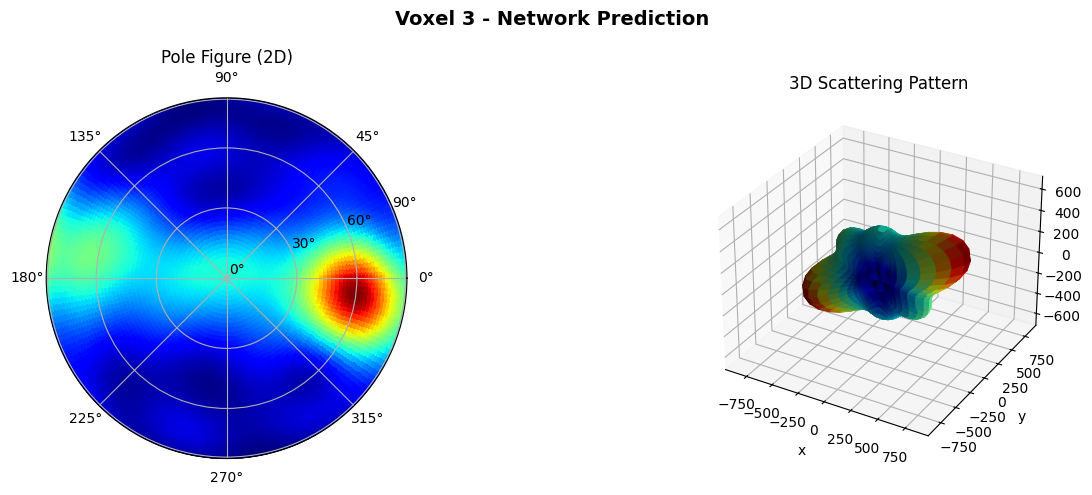


Ground Truth:


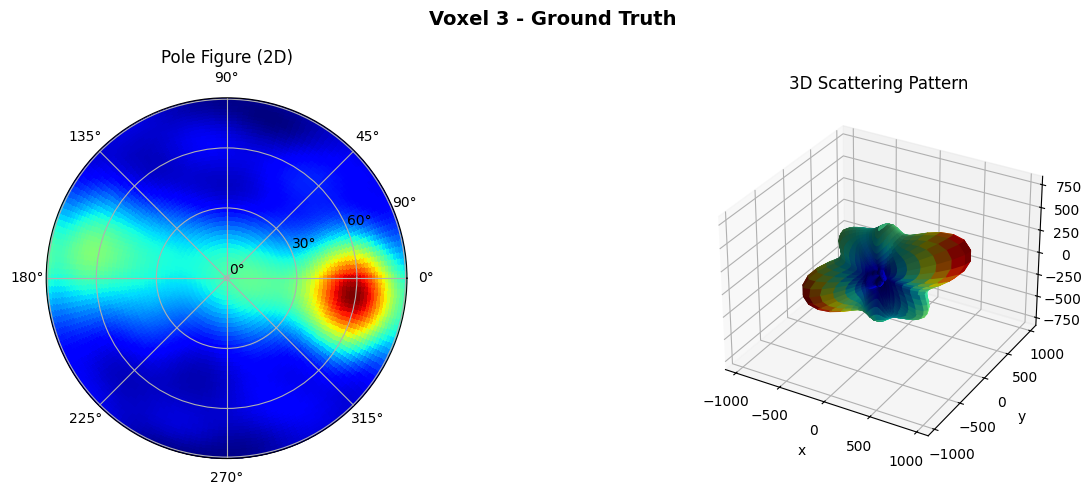


VOXEL 4: Position (27, 76, 55)
MSE (Sparse vs GT): 394.960236
MSE (Predicted vs GT): 149.391663
Improvement: 62.18%

Sparse Reconstruction:


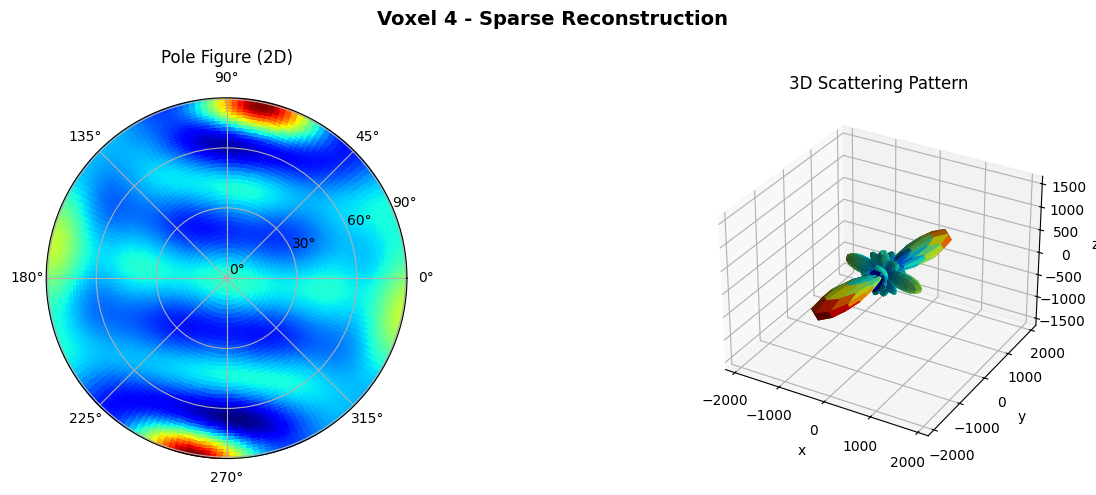


Network Prediction:


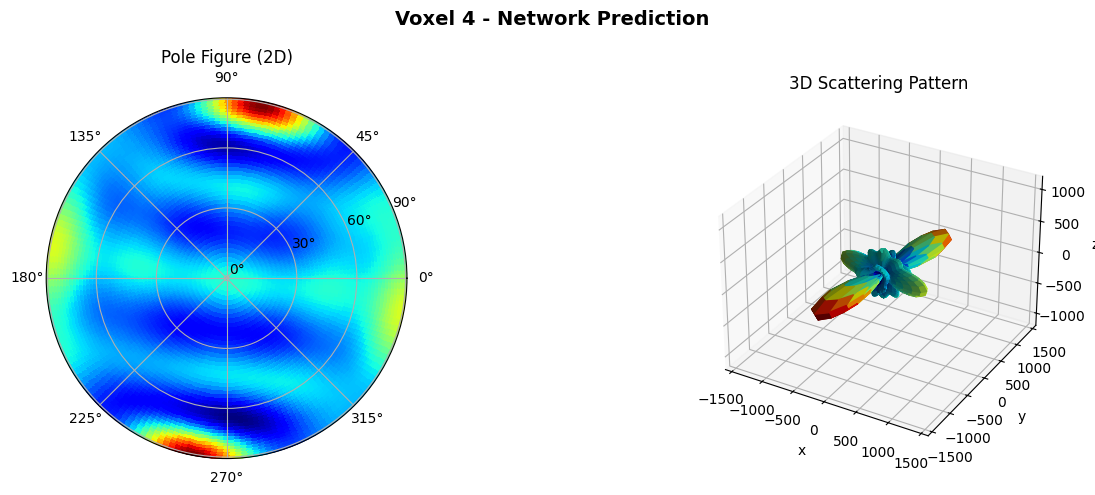


Ground Truth:


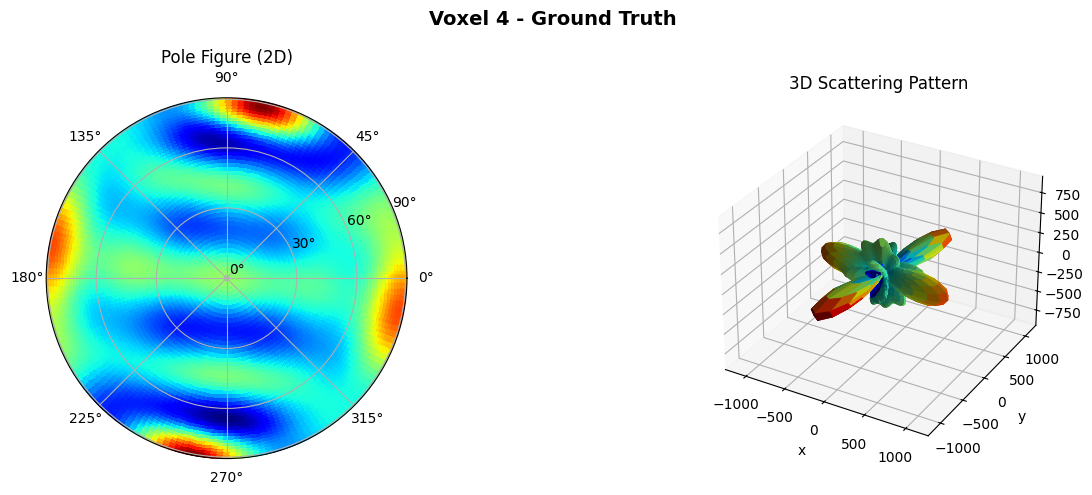


VOXEL 5: Position (40, 74, 7)
MSE (Sparse vs GT): 99.813530
MSE (Predicted vs GT): 111.381958
Improvement: -11.59%

Sparse Reconstruction:


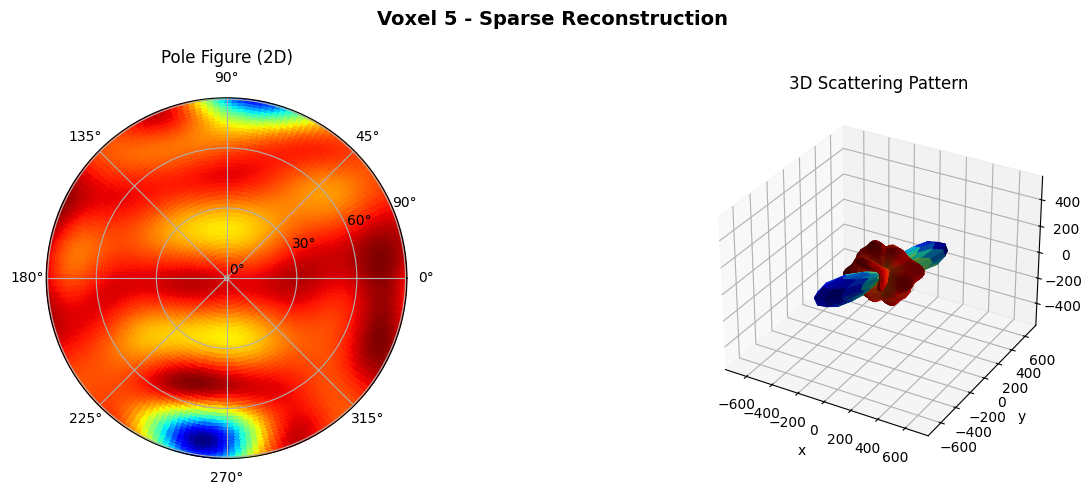


Network Prediction:


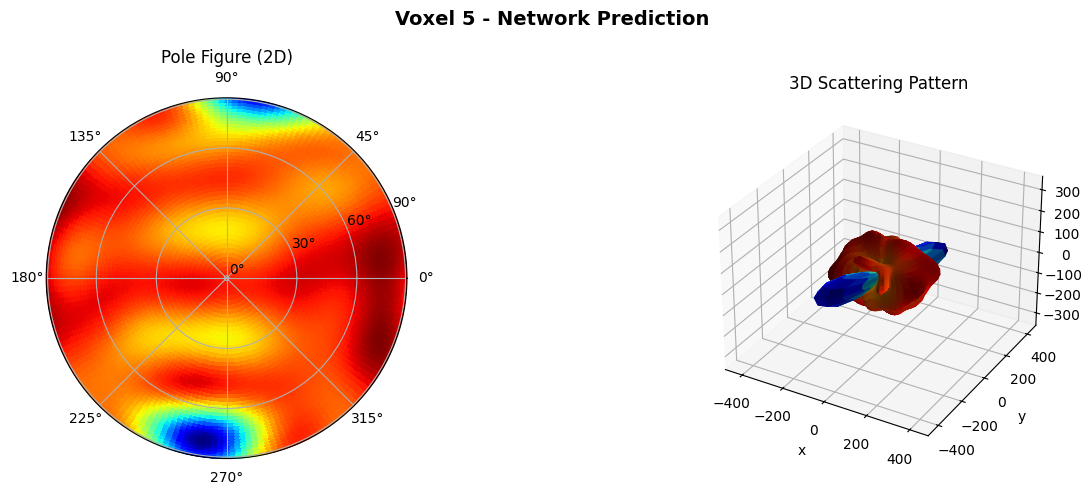


Ground Truth:


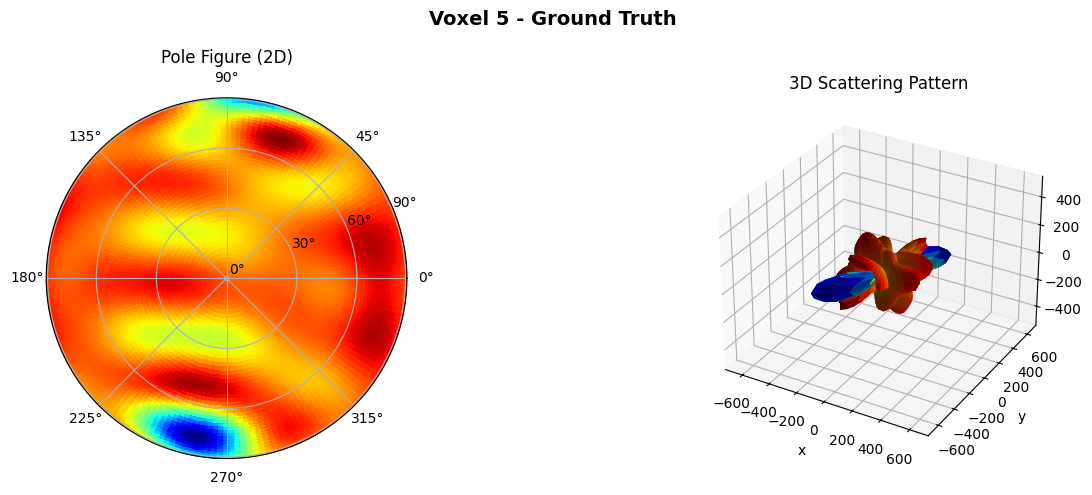

In [82]:
# Visualize each example voxel
for voxel_idx, voxel_pos in enumerate(example_voxels):
    i, j, k = voxel_pos
    
    print(f"\n{'='*70}")
    print(f"VOXEL {voxel_idx + 1}: Position ({i}, {j}, {k})")
    print(f"{'='*70}")
    
    # Extract coefficients for this voxel
    sparse_coeffs = sparse[i, j, k, :]
    pred_coeffs = predicted[i, j, k, :]
    gt_coeffs = gt[i, j, k, :]
    
    # Compute errors
    sparse_error = np.mean((sparse_coeffs - gt_coeffs)**2)
    pred_error = np.mean((pred_coeffs - gt_coeffs)**2)
    improvement = (sparse_error - pred_error) / sparse_error * 100
    
    print(f"MSE (Sparse vs GT): {sparse_error:.6f}")
    print(f"MSE (Predicted vs GT): {pred_error:.6f}")
    print(f"Improvement: {improvement:.2f}%")
    
    # Visualize sparse reconstruction
    print("\nSparse Reconstruction:")
    visualize_sh_function(
        sparse_coeffs, 
        title=f"Voxel {voxel_idx+1} - Sparse Reconstruction"
    )
    
    # Visualize network prediction
    print("\nNetwork Prediction:")
    visualize_sh_function(
        pred_coeffs, 
        title=f"Voxel {voxel_idx+1} - Network Prediction"
    )
    
    # Visualize ground truth
    print("\nGround Truth:")
    visualize_sh_function(
        gt_coeffs, 
        title=f"Voxel {voxel_idx+1} - Ground Truth"
    )

## 6. Coefficient-by-Coefficient Comparison

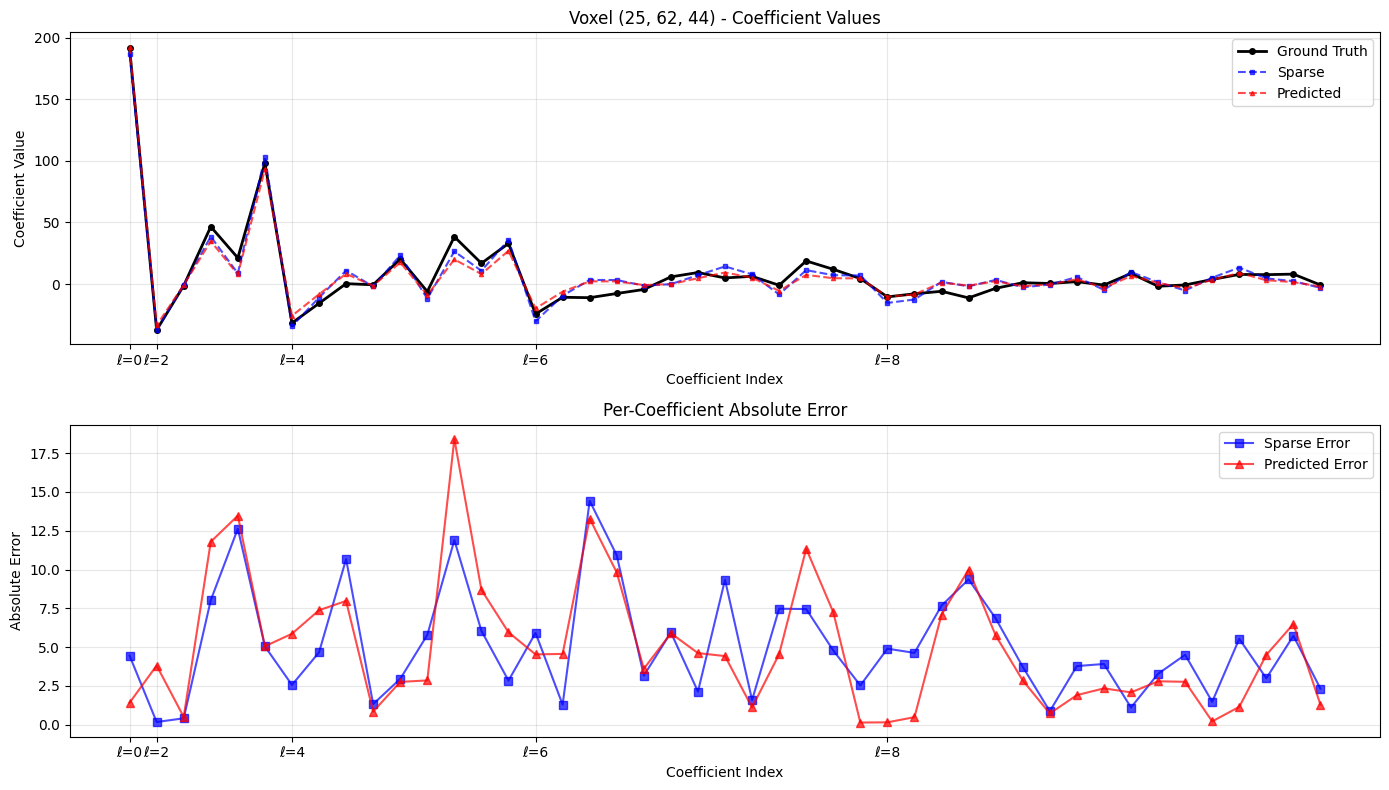

In [76]:
# For a specific voxel, compare coefficients
voxel_idx = 100
voxel_pos = example_voxels[voxel_idx]
i, j, k = voxel_pos

sparse_coeffs = sparse[i, j, k, :]
pred_coeffs = predicted[i, j, k, :]
gt_coeffs = gt[i, j, k, :]

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

x = np.arange(45)

# Coefficient values
axes[0].plot(x, gt_coeffs, 'ko-', label='Ground Truth', linewidth=2, markersize=4)
axes[0].plot(x, sparse_coeffs, 'bs--', label='Sparse', alpha=0.7, markersize=3)
axes[0].plot(x, pred_coeffs, 'r^--', label='Predicted', alpha=0.7, markersize=3)
axes[0].set_xlabel('Coefficient Index')
axes[0].set_ylabel('Coefficient Value')
axes[0].set_title(f'Voxel ({i}, {j}, {k}) - Coefficient Values')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Errors
sparse_error = np.abs(sparse_coeffs - gt_coeffs)
pred_error = np.abs(pred_coeffs - gt_coeffs)

axes[1].plot(x, sparse_error, 'bs-', label='Sparse Error', alpha=0.7)
axes[1].plot(x, pred_error, 'r^-', label='Predicted Error', alpha=0.7)
axes[1].set_xlabel('Coefficient Index')
axes[1].set_ylabel('Absolute Error')
axes[1].set_title('Per-Coefficient Absolute Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Add ℓ value labels
for ax in axes:
    ax.set_xticks([0, 1, 6, 15, 28])
    ax.set_xticklabels(['ℓ=0', 'ℓ=2', 'ℓ=4', 'ℓ=6', 'ℓ=8'])

plt.tight_layout()
plt.show()

Averaging over 3465 voxels (sampling every 10-th voxel)


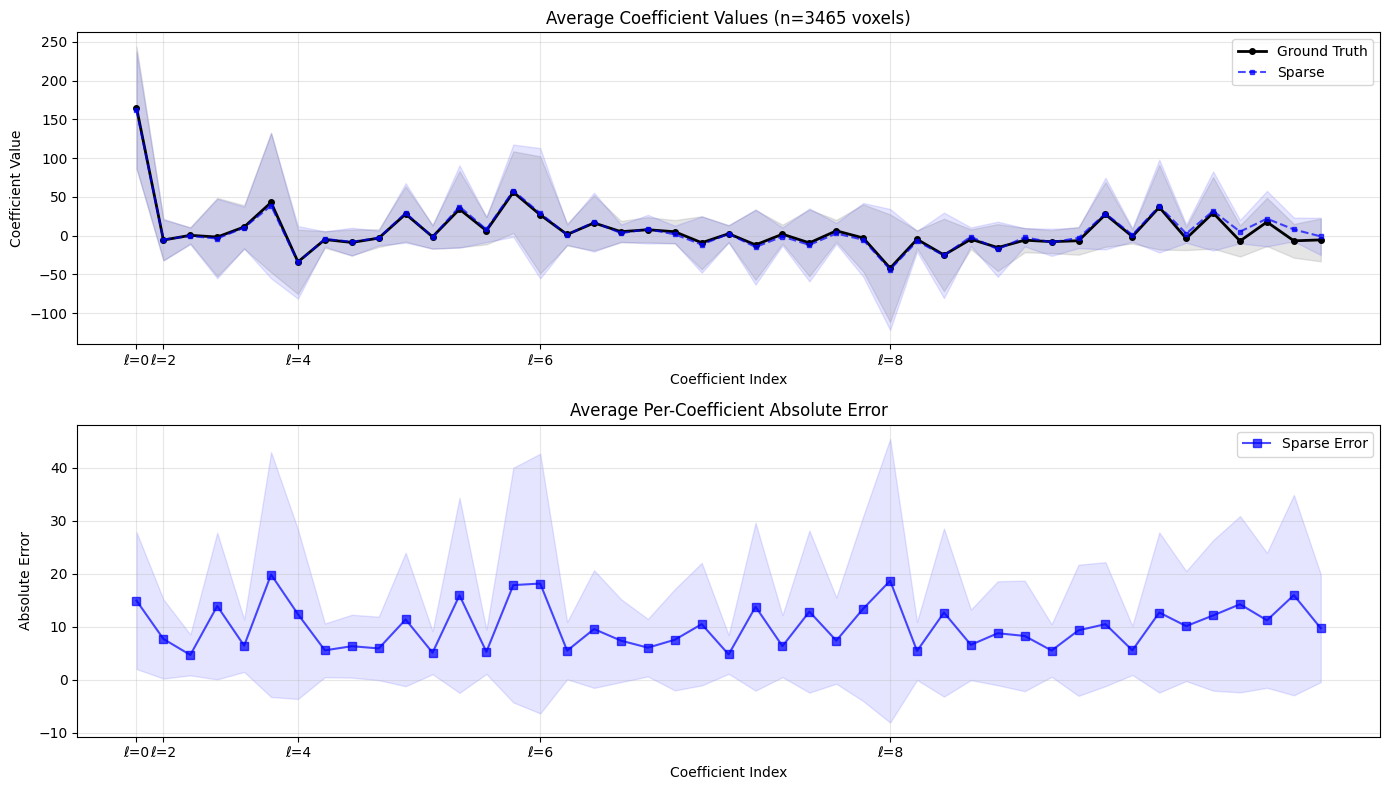


Summary Statistics:
Average MSE (Sparse vs GT): 283.257141
Average MSE (Predicted vs GT): 294.026031
Average MAE (Sparse vs GT): 10.082972
Average MAE (Predicted vs GT): 10.639941


In [88]:
# Average coefficient comparison over multiple voxels
k = 10  # Sample every k-th voxel from high anisotropy voxels

sampled_voxels = high_aniso_coords[::k]
print(f"Averaging over {len(sampled_voxels)} voxels (sampling every {k}-th voxel)")

# Collect coefficients for all sampled voxels
all_sparse_coeffs = []
all_pred_coeffs = []
all_gt_coeffs = []

for voxel_pos in sampled_voxels:
    i, j, k_idx = voxel_pos
    all_sparse_coeffs.append(sparse[i, j, k_idx, :])
    all_pred_coeffs.append(predicted[i, j, k_idx, :])
    all_gt_coeffs.append(gt[i, j, k_idx, :])

# Convert to arrays and compute mean and std
all_sparse_coeffs = np.array(all_sparse_coeffs)
all_pred_coeffs = np.array(all_pred_coeffs)
all_gt_coeffs = np.array(all_gt_coeffs)

mean_sparse = np.mean(all_sparse_coeffs, axis=0)
mean_pred = np.mean(all_pred_coeffs, axis=0)
mean_gt = np.mean(all_gt_coeffs, axis=0)

std_sparse = np.std(all_sparse_coeffs, axis=0)
std_pred = np.std(all_pred_coeffs, axis=0)
std_gt = np.std(all_gt_coeffs, axis=0)

# Compute errors
all_sparse_errors = np.abs(all_sparse_coeffs - all_gt_coeffs)
all_pred_errors = np.abs(all_pred_coeffs - all_gt_coeffs)

mean_sparse_error = np.mean(all_sparse_errors, axis=0)
mean_pred_error = np.mean(all_pred_errors, axis=0)

std_sparse_error = np.std(all_sparse_errors, axis=0)
std_pred_error = np.std(all_pred_errors, axis=0)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

x = np.arange(45)

# Coefficient values with error bands
axes[0].plot(x, mean_gt, 'ko-', label='Ground Truth', linewidth=2, markersize=4)
axes[0].fill_between(x, mean_gt - std_gt, mean_gt + std_gt, color='gray', alpha=0.2)

axes[0].plot(x, mean_sparse, 'bs--', label='Sparse', alpha=0.7, markersize=3)
axes[0].fill_between(x, mean_sparse - std_sparse, mean_sparse + std_sparse, color='blue', alpha=0.1)

# axes[0].plot(x, mean_pred, 'r^--', label='Predicted', alpha=0.7, markersize=3)
# axes[0].fill_between(x, mean_pred - std_pred, mean_pred + std_pred, color='red', alpha=0.1)

axes[0].set_xlabel('Coefficient Index')
axes[0].set_ylabel('Coefficient Value')
axes[0].set_title(f'Average Coefficient Values (n={len(sampled_voxels)} voxels)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Average errors with error bands
axes[1].plot(x, mean_sparse_error, 'bs-', label='Sparse Error', alpha=0.7)
axes[1].fill_between(x, mean_sparse_error - std_sparse_error, mean_sparse_error + std_sparse_error, 
                     color='blue', alpha=0.1)

# axes[1].plot(x, mean_pred_error, 'r^-', label='Predicted Error', alpha=0.7)
# axes[1].fill_between(x, mean_pred_error - std_pred_error, mean_pred_error + std_pred_error, 
#                      color='red', alpha=0.1)

axes[1].set_xlabel('Coefficient Index')
axes[1].set_ylabel('Absolute Error')
axes[1].set_title('Average Per-Coefficient Absolute Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Add ℓ value labels
for ax in axes:
    ax.set_xticks([0, 1, 6, 15, 28])
    ax.set_xticklabels(['ℓ=0', 'ℓ=2', 'ℓ=4', 'ℓ=6', 'ℓ=8'])

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Average MSE (Sparse vs GT): {np.mean(all_sparse_errors**2):.6f}")
print(f"Average MSE (Predicted vs GT): {np.mean(all_pred_errors**2):.6f}")
print(f"Average MAE (Sparse vs GT): {np.mean(all_sparse_errors):.6f}")
print(f"Average MAE (Predicted vs GT): {np.mean(all_pred_errors):.6f}")

## 7. Volume Slices Comparison

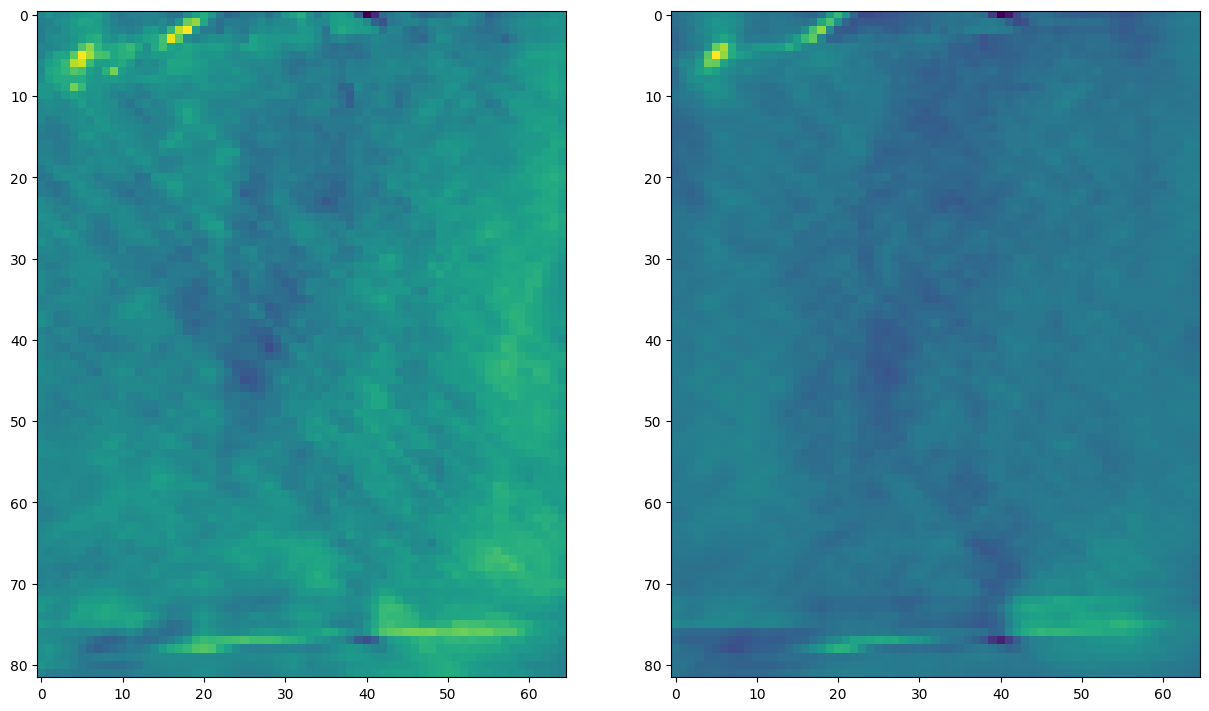

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
slice_idx = 40
coefficient = 2
axes[0].imshow(sparse[slice_idx, :, :, coefficient], cmap='viridis') #label 'ℓ=2, m=0', m=0)')
axes[1].imshow(gt[slice_idx, :, :, coefficient], cmap='viridis')

IndexError: index 2 is out of bounds for axis 0 with size 2

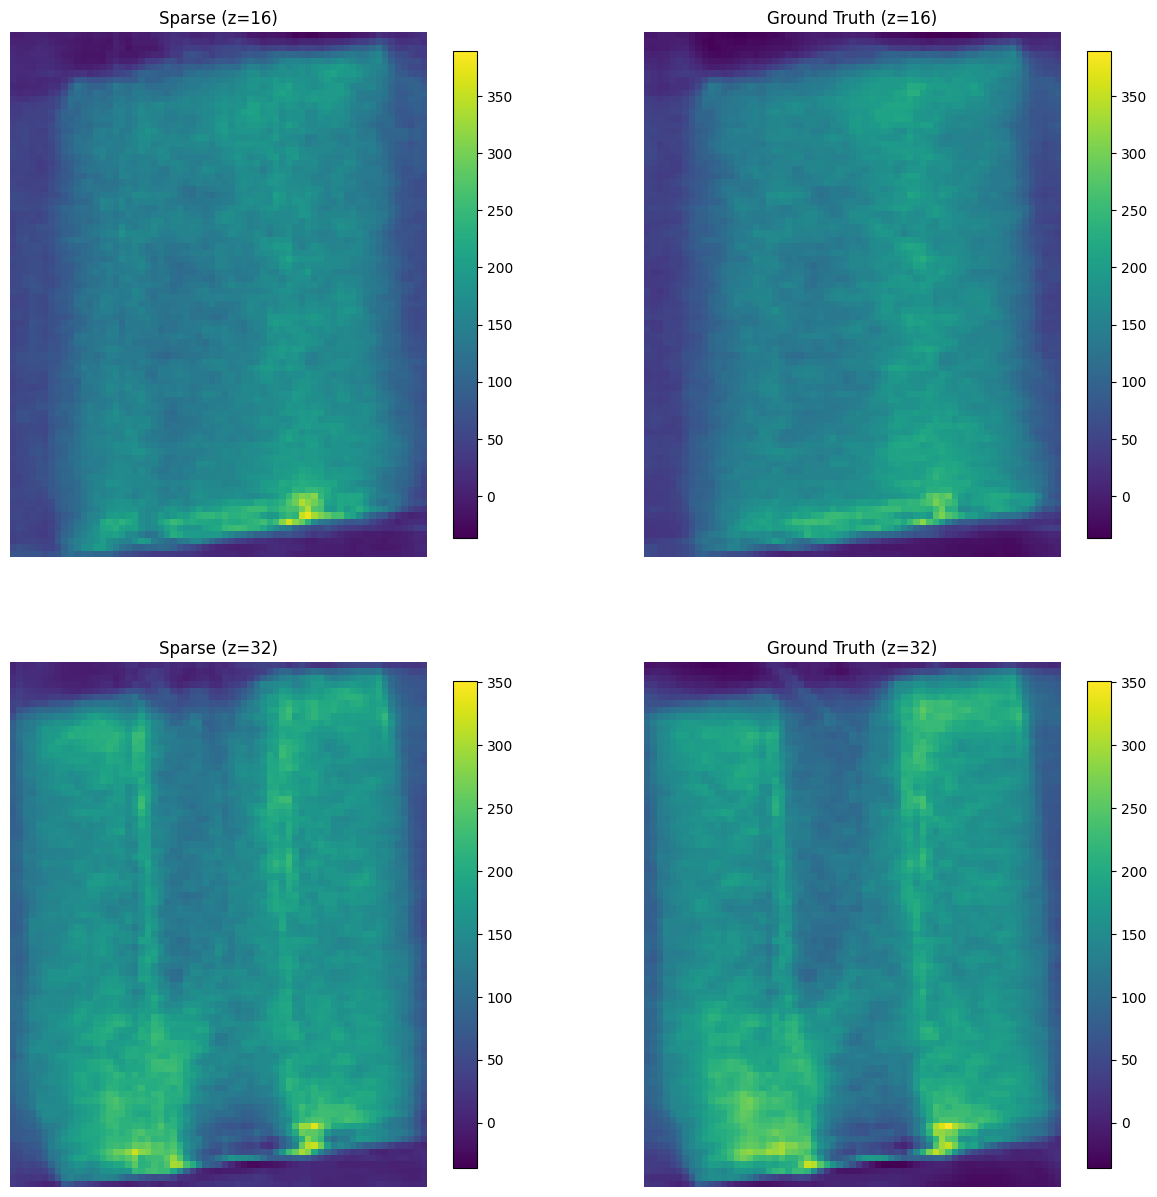

In [98]:
# Show multiple slices for comparison
coeff_idx = 0  # ℓ=0 (isotropic)

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

H, W, D = sparse.shape[:3]
slices_to_show = [D//4, D//2, 3*D//4]

for row, slice_idx in enumerate(slices_to_show):
    vmin = min(
        sparse[:, :, slice_idx, coeff_idx].min(),
        predicted[:, :, slice_idx, coeff_idx].min(),
        gt[:, :, slice_idx, coeff_idx].min()
    )
    vmax = max(
        sparse[:, :, slice_idx, coeff_idx].max(),
        predicted[:, :, slice_idx, coeff_idx].max(),
        gt[:, :, slice_idx, coeff_idx].max()
    )
    
    # Sparse
    im = axes[row, 0].imshow(sparse[:, :, slice_idx, coeff_idx].T, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[row, 0].set_title(f'Sparse (z={slice_idx})')
    axes[row, 0].axis('off')
    plt.colorbar(im, ax=axes[row, 0], fraction=0.046)
    
    # # Predicted
    # im = axes[row, 1].imshow(predicted[:, :, slice_idx, coeff_idx].T, cmap='viridis', vmin=vmin, vmax=vmax)
    # axes[row, 1].set_title(f'Predicted (z={slice_idx})')
    # axes[row, 1].axis('off')
    # plt.colorbar(im, ax=axes[row, 1], fraction=0.046)
    
    # Ground Truth
    im = axes[row, 1].imshow(gt[:, :, slice_idx, coeff_idx].T, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[row, 1].set_title(f'Ground Truth (z={slice_idx})')
    axes[row, 1].axis('off')
    plt.colorbar(im, ax=axes[row, 1], fraction=0.046)

fig.suptitle(f'Volume Slices Comparison (Coefficient {coeff_idx}, ℓ=0)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

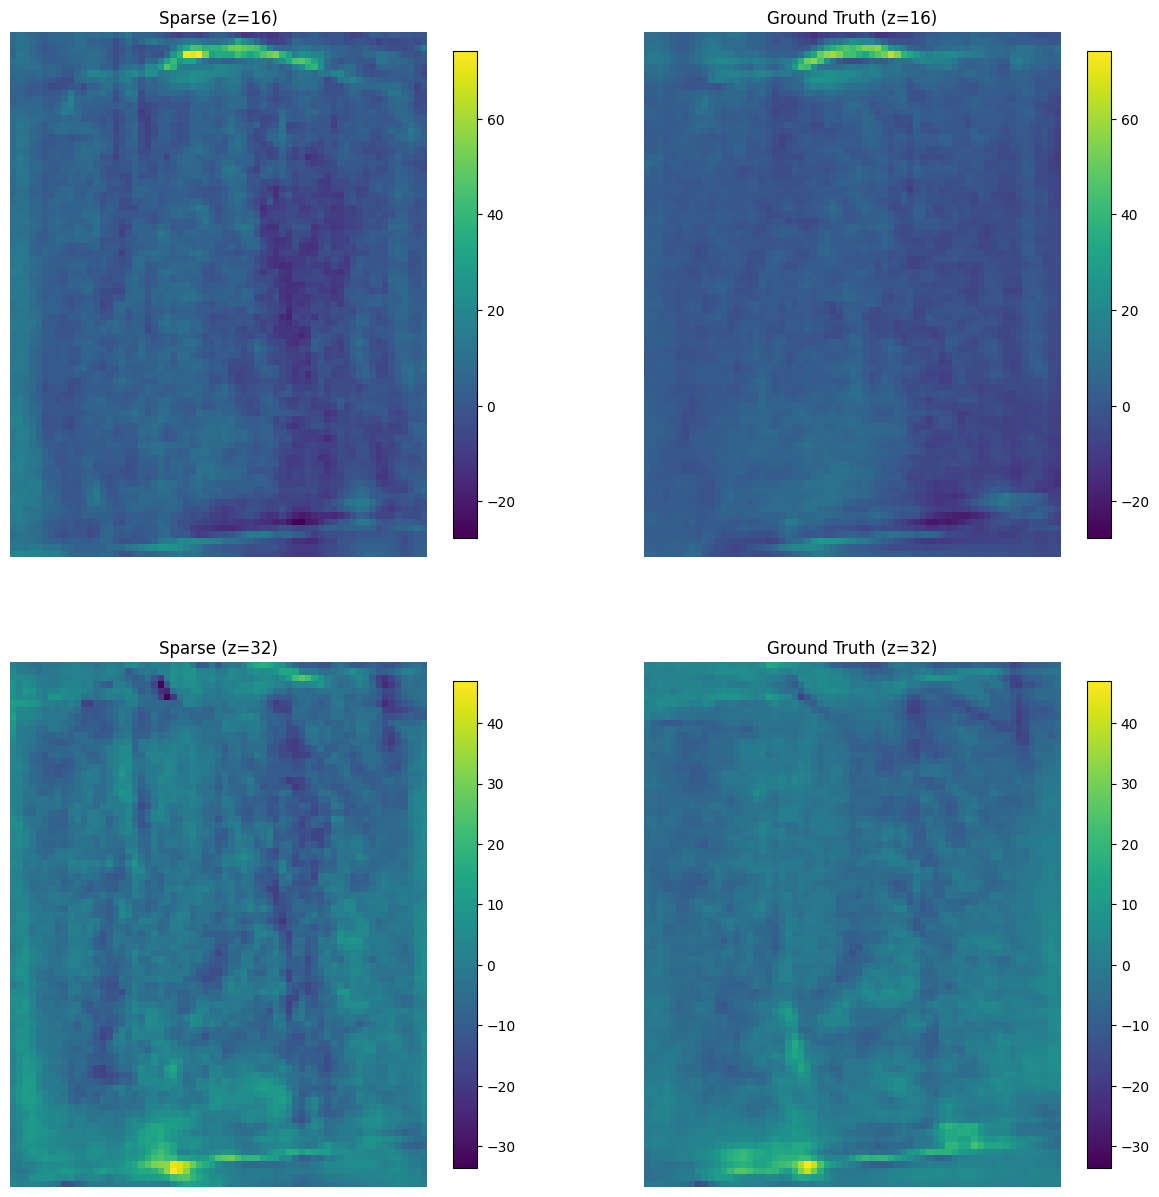

In [ ]:
# Show multiple slices for comparison
coeff_idx = 3  # ℓ=0 (isotropic)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

H, W, D = sparse.shape[:3]
slices_to_show = [D//4, D//2, 3*D//4]

for row, slice_idx in enumerate(slices_to_show):
    vmin = min(
        sparse[:, :, slice_idx, coeff_idx].min(),
        predicted[:, :, slice_idx, coeff_idx].min(),
        gt[:, :, slice_idx, coeff_idx].min()
    )
    vmax = max(
        sparse[:, :, slice_idx, coeff_idx].max(),
        predicted[:, :, slice_idx, coeff_idx].max(),
        gt[:, :, slice_idx, coeff_idx].max()
    )
    
    # Sparse
    im = axes[row, 0].imshow(sparse[:, :, slice_idx, coeff_idx].T, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[row, 0].set_title(f'Sparse (z={slice_idx})')
    axes[row, 0].axis('off')
    plt.colorbar(im, ax=axes[row, 0], fraction=0.046)
    
    # Predicted
    im = axes[row, 1].imshow(predicted[:, :, slice_idx, coeff_idx].T, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[row, 1].set_title(f'Predicted (z={slice_idx})')
    axes[row, 1].axis('off')
    plt.colorbar(im, ax=axes[row, 1], fraction=0.046)
    
    # Ground Truth
    im = axes[row, 2].imshow(gt[:, :, slice_idx, coeff_idx].T, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[row, 2].set_title(f'Ground Truth (z={slice_idx})')
    axes[row, 2].axis('off')
    plt.colorbar(im, ax=axes[row, 2], fraction=0.046)

fig.suptitle(f'Volume Slices Comparison (Coefficient {coeff_idx}, ℓ=0)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()